In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr  3 08:48:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Read Train and test Data
Read all 4 input csv. Concatenation with Total_booking is done later after data preprocessing and splitting the datetime column into year,month,day and hour

In [2]:
import pandas as pd
import numpy as np

# Prepare Training Dataframe
df_train_main = pd.read_csv('train.csv')
df_train_label = pd.read_csv('train_label.csv', names = ['Total_booking'])

# Prepare Test Dataframe
df_test_main = pd.read_csv('test.csv')
df_test_label = pd.read_csv('test_label.csv', names = ['Total_booking'])

In [3]:
print('*** Train Dataset ***\n',df_train_main.head())
print('*** Test Dataset ***\n', df_test_main.head())

*** Train Dataset ***
            datetime  season  holiday  ...   atemp humidity  windspeed
0    5/2/2012 19:00  Summer        0  ...  25.760       77    16.9979
1     9/5/2012 4:00    Fall        0  ...  33.335       79    19.0012
2    1/13/2011 9:00  Spring        0  ...   6.060       50    22.0028
3  11/18/2011 16:00  Winter        0  ...  16.665       29     8.9981
4   9/13/2011 13:00    Fall        0  ...  33.335       51    19.0012

[5 rows x 9 columns]
*** Test Dataset ***
            datetime  season  holiday  ...   atemp humidity  windspeed
0   5/10/2012 11:00  Summer        0  ...  25.000       48    35.0008
1     6/9/2012 7:00  Summer        0  ...  27.275       64     7.0015
2    3/6/2011 20:00  Spring        0  ...  12.120      100    27.9993
3  10/13/2011 11:00  Winter        0  ...  28.790       83     0.0000
4    6/2/2012 12:00  Summer        0  ...  31.060       43    23.9994

[5 rows x 9 columns]


# Data Preprocessing

In [4]:
# Check the datatypes of columns in train dataset
df_train_main.dtypes

datetime       object
season         object
holiday         int64
workingday      int64
weather        object
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [5]:
# Check missing values in train dataset
df_train_main.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [6]:
# Drop atemp from train and test dataset because temp and atemp represent same data
df_train_main = df_train_main.drop(['atemp'], axis = 1)
df_test_main = df_test_main.drop(['atemp'], axis = 1)

In [7]:
# Convert datetime columns from datatpe object to datetime
df_train_main['datetime'] = pd.to_datetime(df_train_main['datetime'])
df_test_main['datetime'] = pd.to_datetime(df_test_main['datetime'])

In [8]:
# Cross check datatypes again
df_train_main.dtypes

datetime      datetime64[ns]
season                object
holiday                int64
workingday             int64
weather               object
temp                 float64
humidity               int64
windspeed            float64
dtype: object

In [9]:
#### Split Datetime into components - Year, Month, Date, Day. Hour
#### Drop Datetime column after splitting

# df_train
df_train_main['Year'] = df_train_main['datetime'].dt.year
df_train_main['Month'] = df_train_main['datetime'].dt.month
df_train_main['Date'] = df_train_main['datetime'].dt.day
df_train_main['Weekday'] = df_train_main['datetime'].dt.weekday
df_train_main['Hour'] = df_train_main['datetime'].dt.hour
df_train_main = df_train_main.drop(['datetime'], axis = 1)

# df_test
df_test_main['Year'] = df_test_main['datetime'].dt.year
df_test_main['Month'] = df_test_main['datetime'].dt.month
df_test_main['Date'] = df_test_main['datetime'].dt.day
df_test_main['Weekday'] = df_test_main['datetime'].dt.weekday
df_test_main['Hour'] = df_test_main['datetime'].dt.hour
df_test_main = df_test_main.drop(['datetime'], axis = 1)

column_list = ['season','holiday','workingday','weather','temp','humidity','windspeed','Year',
               'Month','Date','Weekday','Hour']

In [10]:
# Cross check datatypes again
df_train_main.dtypes

season         object
holiday         int64
workingday      int64
weather        object
temp          float64
humidity        int64
windspeed     float64
Year            int64
Month           int64
Date            int64
Weekday         int64
Hour            int64
dtype: object

In [11]:
# Use LabelEncoder to Convert categorical data Season and Weather to numeric
from sklearn.preprocessing import LabelEncoder

# Season
le_season = LabelEncoder()
df_train_main['season'] = le_season.fit_transform(df_train_main['season'])
df_test_main['season'] = le_season.transform(df_test_main['season'])

# Weather
le_weather = LabelEncoder()
df_train_main['weather'] = le_weather.fit_transform(df_train_main['weather'])
df_test_main['weather'] = le_weather.transform(df_test_main['weather'])

In [12]:
# Reduce 2000 from year column so that data is in level with other columns
df_train_main['Year'] = df_train_main['Year'] - 2000
df_test_main['Year'] = df_test_main['Year'] - 2000

print(df_train_main.head())

   season  holiday  workingday  weather  ...  Month  Date  Weekday  Hour
0       2        0           1        0  ...      5     2        2    19
1       0        0           1        0  ...      9     5        2     4
2       1        0           1        0  ...      1    13        3     9
3       3        0           1        0  ...     11    18        4    16
4       0        0           1        0  ...      9    13        1    13

[5 rows x 12 columns]


In [13]:
# Cross check datatypes again
df_train_main.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
humidity        int64
windspeed     float64
Year            int64
Month           int64
Date            int64
Weekday         int64
Hour            int64
dtype: object

Concatenate the Total_Booking into train and test datasets

In [14]:
# Concatenate the Total_Booking column in train and test datasets

df_train = pd.concat([df_train_main,df_train_label], axis = 1)
df_test = pd.concat([df_test_main,df_test_label], axis = 1)

print(df_train.head())

   season  holiday  workingday  weather  ...  Date  Weekday  Hour  Total_booking
0       2        0           1        0  ...     2        2    19            504
1       0        0           1        0  ...     5        2     4              5
2       1        0           1        0  ...    13        3     9            139
3       3        0           1        0  ...    18        4    16            209
4       0        0           1        0  ...    13        1    13            184

[5 rows x 13 columns]


# Outlier Analysis and removal using IQR
Not removing outliers from categorical columns. So only temp, humidity and windspeed are non categorical data from which outliers are being removed

In [15]:
old_shape = df_train.shape

####################################################################
#   REMOVE OUTLIERS USING IQR and create new dataframe after it
####################################################################
# Split data into X,y - This is just to take columns names only for features
feature = df_train.iloc[ : ,0:-1]
dependant_var = df_train.iloc[ : ,-1]
my_list = ['temp','humidity','windspeed'] # Other all data are categorical hence no outlier analysis done on those

# Find Upper Bound and Lower Bound per column and store in a Dataframe - df_ub_lb
df_ub_lb = pd.DataFrame(columns = ['Column Name', 'Upper Bound', 'Lower Bound'])
row_num = 0
for x in my_list:
    cur_col = df_train.loc[:,x]
    cur_col_sorted = cur_col.sort_values()
    iqr = cur_col_sorted.quantile(0.75) - cur_col_sorted.quantile(0.25)
    upper_bound = cur_col_sorted.quantile(0.75) + (1.5 * iqr)
    lower_bound = cur_col_sorted.quantile(0.25) - (1.5 * iqr)
    my_row = [x,upper_bound,lower_bound]
    df_ub_lb.loc[len(df_ub_lb)] = my_row
display(df_ub_lb)

#Remove Rows beyond upper bound and lower bound
for x in my_list:
    # Use the lb and ub dataframe fro previous for loop to find ub and lb for the specific columns
    df_ub_lb_col = df_ub_lb.loc[df_ub_lb['Column Name'] == x]
    df_ub_lb_col = df_ub_lb_col.reset_index()
    lb = df_ub_lb_col.loc[0,'Lower Bound']
    ub = df_ub_lb_col.loc[0,'Upper Bound']
    # Remove data from the main dataframe
    df_train.drop(df_train[df_train[x] > ub].index, inplace = True)
    df_train.drop(df_train[df_train[x] < lb].index, inplace = True)

new_shape = df_train.shape
print('Shape of original dataframe: ', old_shape)
print('Shape after removing outliers: ', new_shape)

,Column Name,Upper Bound,Lower Bound
0,temp,44.6900,-4.5100
1,humidity,123.5000,-0.5000
2,windspeed,31.9925,-7.9931


Shape of original dataframe:  (8708, 13)
Shape after removing outliers:  (8526, 13)


# Feature Scaling for Train and Test both - Not  Done here

In [ ]:
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_train_main = pd.DataFrame(scaler.fit_transform(df_train_main),columns= column_list)
df_test_main = pd.DataFrame(scaler.transform(df_test_main),columns= column_list)

print(df_train_main.head())
print(df_test_main.head())
'''

'\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\n\ndf_train_main = pd.DataFrame(scaler.fit_transform(df_train_main),columns= column_list)\ndf_test_main = pd.DataFrame(scaler.transform(df_test_main),columns= column_list)\n\nprint(df_train_main.head())\nprint(df_test_main.head())\n'

# Graphical Analysis

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

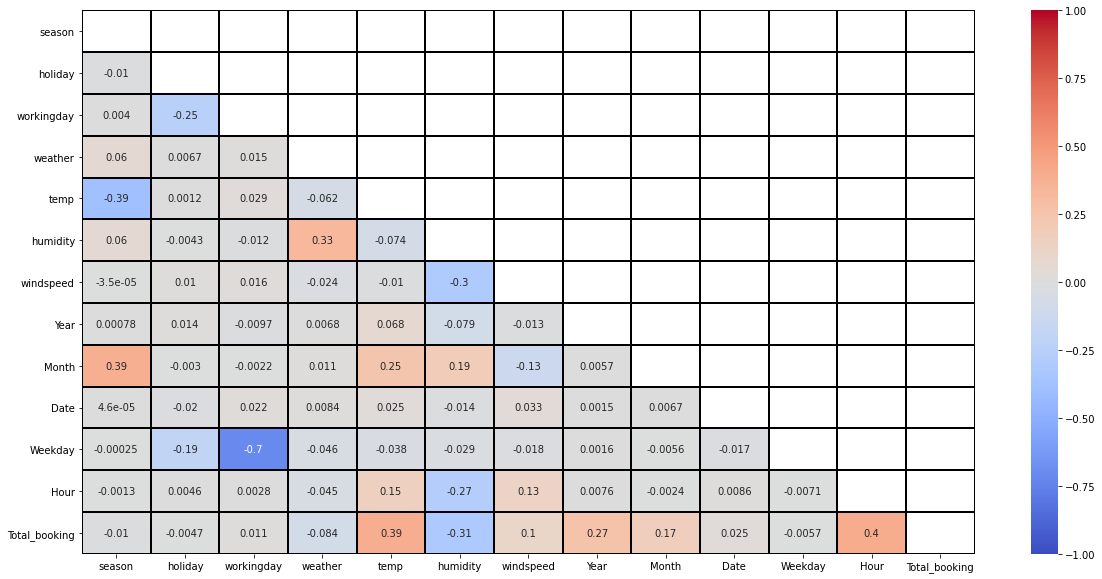

In [17]:
# Co-relation Heatmap

import numpy as np
matrix = np.triu(df_train.corr())
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_train.corr(), annot = True , vmin =-1 , vmax = 1, center = 0, cmap= 'coolwarm', 
            mask = matrix,linewidth=1, linecolor = 'black')

Observation - 
1. Weekday and Working day are negatively related
2. Total booking seems positively related to Hour and temp

Bar Plots based on SUM OF TOTAL BOOKING based on categories in different columns


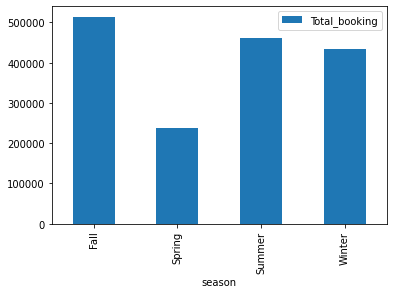

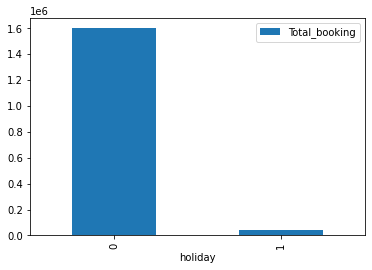

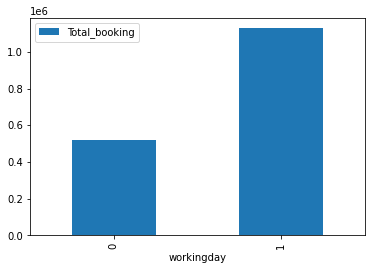

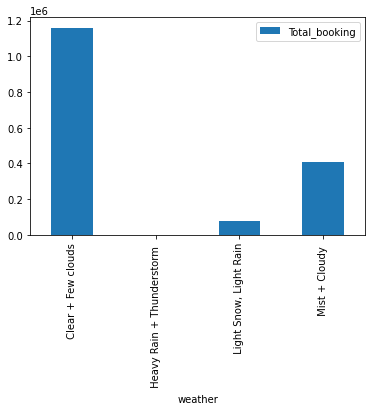

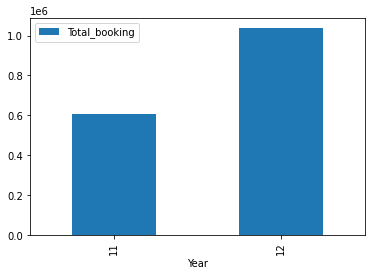

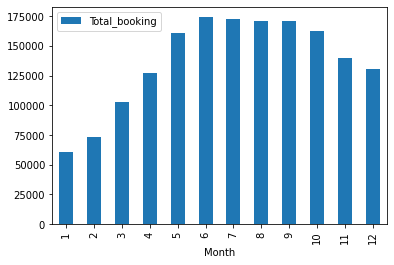

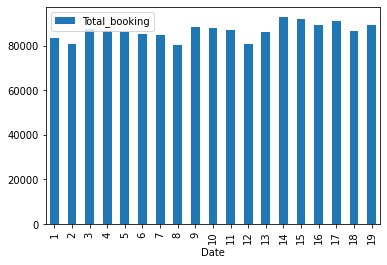

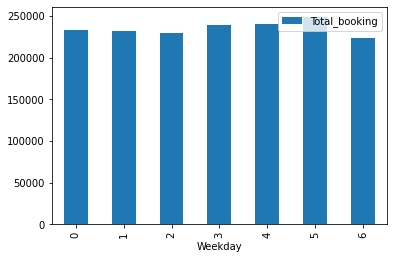

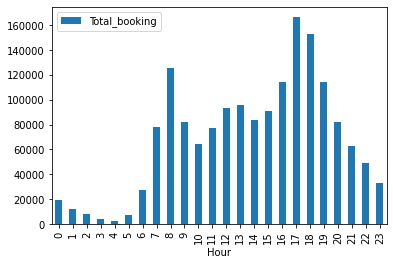

In [18]:
# Bar Plots - Categorical values columns - SUM Vs Total_booking

columns_list = ['season', 'holiday', 'workingday', 'weather', 'Year', 'Month', 'Date', 'Weekday', 'Hour']

df_for_plotting = df_train
df_for_plotting['season'] = le_season.inverse_transform(df_for_plotting['season'])
df_for_plotting['weather'] = le_weather.inverse_transform(df_for_plotting['weather'])
#df_for_plotting['Year'] = le_weather.inverse_transform(df_for_plotting['Year'])

print('Bar Plots based on SUM OF TOTAL BOOKING based on categories in different columns')

for col in columns_list:
    pivot_plot = pd.pivot_table(df_for_plotting,
                                  columns = col,
                                  values = 'Total_booking',
                                  aggfunc = np.sum,                    #### SUM
                                  fill_value = 0)
    df_plot = pd.DataFrame(pivot_plot)
    df_plot = df_plot.T
    df_plot = df_plot.reset_index()
    df_plot.plot.bar(x=col, y='Total_booking', rot=90)

Bar Plots based on SUM OF TOTAL BOOKING based on categories in different columns


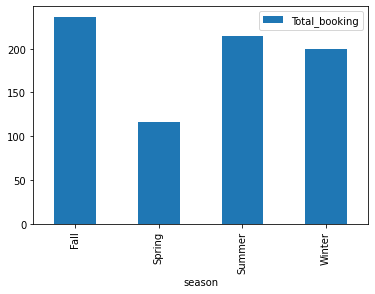

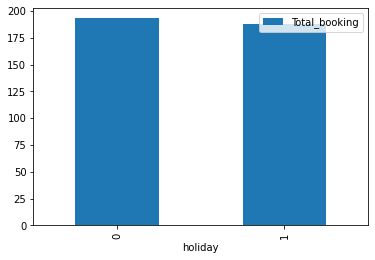

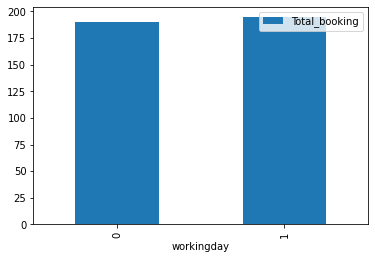

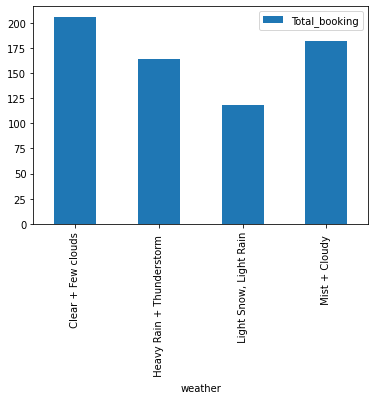

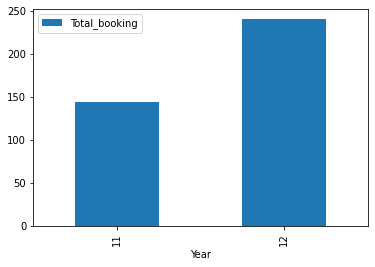

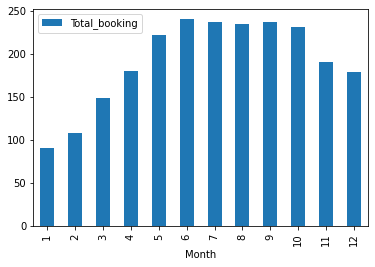

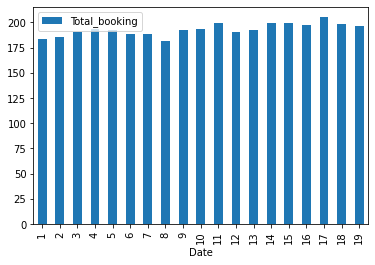

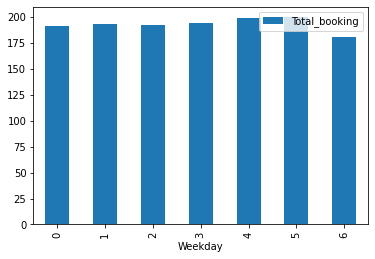

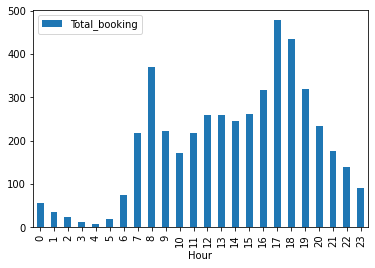

In [19]:
# Bar Plots - Categorical values columns - MEAN Vs Total_booking

print('Bar Plots based on SUM OF TOTAL BOOKING based on categories in different columns')

for col in columns_list:
    pivot_plot = pd.pivot_table(df_for_plotting,
                                columns = col,
                                values = 'Total_booking',
                                aggfunc = np.mean,                    #### MEAN
                                fill_value = 0)
    df_plot = pd.DataFrame(pivot_plot)
    df_plot = df_plot.T
    df_plot = df_plot.reset_index()
    df_plot.plot.bar(x=col, y='Total_booking', rot=90)

# Split data to X_train, X_test, y_train and y_test

In [20]:
# Apply Label Encodding back to df_train
df_train['season'] = le_season.fit_transform(df_train['season'])
df_train['weather'] = le_weather.fit_transform(df_train['weather'])
#df_train['Year'] = le_year.fit_transform(df_train['Year'])

print(df_train.head())
print(df_test.head())

   season  holiday  workingday  weather  ...  Date  Weekday  Hour  Total_booking
0       2        0           1        0  ...     2        2    19            504
1       0        0           1        0  ...     5        2     4              5
2       1        0           1        0  ...    13        3     9            139
3       3        0           1        0  ...    18        4    16            209
4       0        0           1        0  ...    13        1    13            184

[5 rows x 13 columns]
   season  holiday  workingday  weather  ...  Date  Weekday  Hour  Total_booking
0       2        0           1        0  ...    10        3    11            256
1       2        0           0        0  ...     9        5     7             87
2       1        0           0        2  ...     6        6    20             11
3       3        0           1        3  ...    13        3    11             84
4       2        0           0        0  ...     2        5    12            668

[5 r

In [21]:
X_train = df_train.iloc[:,0:-1]
y_train = df_train.iloc[:,-1]

X_test = df_test.iloc[:,0:-1]
y_test = df_test.iloc[:,-1]

# Create Grid Search function

In [22]:
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error,r2_score)

def FitModel(x_train_L,y_train_L,x_test_L,y_test_L,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    
    grid = GridSearchCV(
        estimator=algorithm,
        param_grid=gridSearchParams,
        cv=cv,  verbose=1, n_jobs=-1)
    
    grid_result = grid.fit(x_train_L, y_train_L)
    best_params = grid_result.best_params_
    pred = grid_result.predict(x_test_L)
    
    print('Best Params :',best_params)
    print('R2 Score {}'.format(r2_score(y_test_L,pred)))
    print('Root Mean squared error {}'.format(sqrt(mean_squared_error(y_test_L,pred))))

# Apply Regression models and pass through Grid Search Function to get best parameters

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

dt_params = {
    'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth' : [5,10,15,20,25,50,100,150,200]
}

FitModel(X_train,y_train,X_test,y_test,'Decision Tree',DecisionTreeRegressor(random_state = 0),dt_params,cv=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.8s


Best Params : {'criterion': 'mse', 'max_depth': 50, 'splitter': 'best'}
R2 Score 0.9036322535999006
Root Mean squared error 55.68856071319049


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   41.3s finished


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_params = {
    'n_estimators' : [50,100,150,200,300,500],
    'criterion' : ['mse', 'mae'],
    'max_depth' : [2,3,4,5,6,7]
}

FitModel(X_train,y_train,X_test,y_test,'Random Tree',RandomForestRegressor(random_state = 0),rf_params,cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 112.3min finished


Best Params : {'criterion': 'mse', 'max_depth': 7, 'n_estimators': 200}
R2 Score 0.8394165265166555
Root Mean squared error 71.88703409430587


In [ ]:
# Support Vector
from sklearn.svm import SVR

svr_params = {
    'kernel': ['rbf', 'sigmoid'],  #'precomputed' is excluded as there was error and linear, polynomial also excluded due to high runtime
    'epsilon' : [0.1,1,5,10,15],
    'gamma' : ['scale', 'auto', 0.001, 0.01, 0.1, 1, 3, 5],
    'C': [0.1, 1, 100, 1000],
}

FitModel(X_train,y_train,X_test,y_test,'SVM',SVR(),svr_params,cv = 5)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed: 34.4min finished


Best Params : {'C': 1000, 'epsilon': 15, 'gamma': 0.01, 'kernel': 'rbf'}
R2 Score 0.6509380297093754
Root Mean squared error 105.98670971033253


In [ ]:
# Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

deg = 1
while deg <= 5:
    poly_reg = PolynomialFeatures(degree = deg)
    X_poly = poly_reg.fit_transform(X_train)
    regressor = LinearRegression()
    regressor.fit(X_poly,y_train)
    
    y_pred = pd.DataFrame(regressor.predict(poly_reg.transform(X_test)),columns = ['y_pred'])
    print(y_pred.head())
    deg = deg + 1
    
    print('R2 Score: ',r2_score(y_test,y_pred))

       y_pred
0  275.558283
1  223.265521
2   55.068126
3  183.619355
4  323.572414
R2 Score:  0.40056152578484494
       y_pred
0  331.824794
1  271.565715
2 -121.615786
3  243.291461
4  427.584061
R2 Score:  0.5517304468741078
       y_pred
0  360.648698
1  236.918041
2  -12.551814
3  228.280469
4  500.134108
R2 Score:  0.6128647964761169
       y_pred
0  296.377731
1  168.575142
2  -15.759154
3  138.064525
4  614.764541
R2 Score:  -20.762417503303116
       y_pred
0   40.910885
1  127.516160
2 -123.447453
3   84.998892
4  706.035909
R2 Score:  -157.657398456846


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

param ={
            'n_estimators': [50,100,500,700,1000,2000],
            'max_depth':[2,3,4,5],
             'min_samples_split':range(200,1001,200),
            'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.5]
        }
FitModel(X_train,y_train,X_test,y_test,'GradientBoostingRegressor',GradientBoostingRegressor(),param,cv=5)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 74.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 95.6min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 110.1min finished


Best Params : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 2000}
R2 Score 0.9580969097621479
Root Mean squared error 36.72173296739828


# Implementing GradientBoostRegressor with Best Params : {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 2000}

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_reg = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 5, min_samples_split = 200, n_estimators = 2000)
gbr_reg.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=200,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
# Make predictions on y_test

y_pred = pd.DataFrame(gbr_reg.predict(X_test), columns = ['Prediction'])

# Prepare final of test values with predictions
df_test_final = pd.read_csv('test.csv')
df_test_label_final = pd.read_csv('test_label.csv', names = ['Total_booking'])

df_test_final= pd.concat([df_test_final,df_test_label_final,y_pred], axis = 1)
print(df_test_final.head())

# Write the dataframe to csv
df_test_final.to_csv('Prediction.csv', index = False)

           datetime  season  holiday  ...  windspeed Total_booking  Prediction
0   5/10/2012 11:00  Summer        0  ...    35.0008           256  217.689550
1     6/9/2012 7:00  Summer        0  ...     7.0015            87  155.494791
2    3/6/2011 20:00  Spring        0  ...    27.9993            11   22.458269
3  10/13/2011 11:00  Winter        0  ...     0.0000            84   92.774392
4    6/2/2012 12:00  Summer        0  ...    23.9994           668  600.858043

[5 rows x 11 columns]


**Synopsis** - 

From bar plots we can see below observations - 
1. 1700 and 1800 are peak times so more numnber of cabs are needed
2. Morning 0800 and evening 1600 and 1900 have also high bookings
3. Month 5 to 10 have relatively higher booking might be due to monsoon with month 6 being highest
4. Weather - Clear + Few clouds --> More booking seen

From Grid search we can see that Decision Tree Regression model is the best model with R2 Score of around .96 with parameters - 
1. learning_rate = 0.1
2. max_depth = 5
3. min_samples_split = 200
4. n_estimators = 2000

Hence we will apply Gradient Boost Regressor for this data set with the parameters mentioned above.

